#Preprocessing

##Sentiment Analysis

In [ ]:
import pandas as pd
from textblob import TextBlob

# Load the dataset
df = pd.read_csv("/content/labeled_data.csv")

# Function to calculate sentiment scores
def get_sentiment(text):
    blob = TextBlob(str(text))  # Ensure text is string
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis
df[['polarity', 'subjectivity']] = df['tweet'].apply(lambda x: pd.Series(get_sentiment(x)))

# Print summary statistics
print(df.groupby('class')[['polarity', 'subjectivity']].mean())

# Save results
df.to_csv("/content/labeled_with_sentiment.csv", index=False)


       polarity  subjectivity
class                        
0     -0.071342      0.391782
1     -0.007437      0.382190
2      0.081524      0.320158


##Data Cleansing: Missing data and Contradictions Check

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Check for duplicates
duplicate_tweets = df[df.duplicated(subset=['tweet'], keep=False)]
print(f"\nDuplicate Tweets Found: {len(duplicate_tweets)}")

# Check for contradictions (equal votes in class assignment)
# Assuming no additional voting columns, just verifying class label integrity
contradictions = df['class'].value_counts()
print("\nClass Distribution:\n", contradictions)

# Save cleaned data
df.drop_duplicates(subset=['tweet'], keep='first', inplace=True)
df.to_csv("cleaned_labeled.csv", index=False)
print("\nData Cleansing Completed!")


Missing Values:
 Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
polarity              0
subjectivity          0
dtype: int64

Duplicate Tweets Found: 0

Class Distribution:
 class
1    19190
2     4163
0     1430
Name: count, dtype: int64

Data Cleansing Completed!


## Data Preprocessing
1.Conversion of text to all lower-case characters

2.Removal of special characters, “@user” etc. symbols in
tweet

3.Handling Hashtags in the tweet rather than simply removing them since Hashtags contains important information

4.Elimination of markups and Removal of URLs using regex


In [ ]:
import re
import pandas as pd
from textblob import TextBlob


# Load dataset
df = pd.read_csv("cleaned_labeled.csv")

# Function to preprocess tweets
def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()

    # Remove mentions, URLs, special characters
    tweet = re.sub(r"@\w+", "", tweet)  # Remove @user
    tweet = re.sub(r"http\S+|www\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^a-zA-Z0-9#\s]", "", tweet)  # Remove special characters except hashtags

    # Handle hashtags (keep words, remove #)
    tweet = re.sub(r"#(\w+)", r"\1", tweet)  # Keep hashtag content
    return tweet

# Apply preprocessing
df["cleaned_tweet"] = df["tweet"].apply(preprocess_tweet)

# Save the cleaned data
df.to_csv("preprocessed_labeled.csv", index=False)

print("Preprocessing Completed! ✅")


Preprocessing Completed! ✅


In [ ]:
pip install nlpaug textblob nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 26.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import random
import nlpaug.augmenter.word as naw
import nltk
from nltk.corpus import wordnet

nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")

# Load dataset
df = pd.read_csv("preprocessed_labeled.csv")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df0 = pd.read_csv('preprocessed_labeled.csv')
df0.head()
df0.tail()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,polarity,subjectivity,cleaned_tweet
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,0.357143,0.535714,yous a muthafin lie 8220 right his tl is tra...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",-0.550000,0.900000,youve gone and broke the wrong heart baby and ...
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,0.156250,0.400000,young buck wanna eat dat nigguh like i aint fu...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,0.100000,0.400000,youu got wild bitches tellin you lies
24782,25296,3,0,0,3,2,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...,0.187500,0.325000,ruffled ntac eileen dahlia beautiful color c...


## Data Augmentation

In [ ]:
# Function to replace words with synonyms using WordNet
def synonym_replacement(tweet, n=2):
    words = nltk.word_tokenize(tweet)
    new_words = words.copy()
    random_words = [word for word in words if word.isalpha()]  # Exclude special characters

    if len(random_words) < n:
        return tweet  # Not enough words to replace

    random.shuffle(random_words)
    num_replaced = 0

    for word in random_words:
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name())

        if len(synonyms) > 0:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if w == word else w for w in new_words]
            num_replaced += 1

        if num_replaced >= n:
            break

    return " ".join(new_words)


# Function for Random Insertion (insert synonyms)
def random_insertion(tweet, n=2):
    words = nltk.word_tokenize(tweet)
    for _ in range(n):
        synonyms = []
        random_word = random.choice(words)

        for syn in wordnet.synsets(random_word):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())

        if len(synonyms) > 0:
            synonym = random.choice(synonyms)
            random_idx = random.randint(0, len(words) - 1)
            words.insert(random_idx, synonym)

    return " ".join(words)


# Function for Random Swapping
def random_swap(tweet, n=2):
    words = nltk.word_tokenize(tweet)
    if len(words) < 2:
        return tweet

    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]

    return " ".join(words)


# Function for Random Deletion
def random_deletion(tweet, p=0.2):
    words = nltk.word_tokenize(tweet)
    if len(words) == 1:
        return tweet  # Avoid empty sentences

    new_words = [word for word in words if random.uniform(0, 1) > p]
    return " ".join(new_words)


In [ ]:
# Apply augmentation only to minority classes
augmented_tweets = []

for _, row in df.iterrows():
    tweet, label = row["cleaned_tweet"], row["class"]

    if not isinstance(tweet, str):  # Convert NaN or non-string values
        tweet = str(tweet)

    augmented_tweets.append((tweet, label))  # Original tweet

    if label in [0, 2]:  # Augment only for Hate (0) & Neither (2)
        augmented_tweets.append((synonym_replacement(tweet), label))
        augmented_tweets.append((random_insertion(tweet), label))
        augmented_tweets.append((random_swap(tweet), label))
        augmented_tweets.append((random_deletion(tweet), label))

# Convert to DataFrame
aug_df = pd.DataFrame(augmented_tweets, columns=["tweet", "class"])

# Save the augmented dataset
aug_df.to_csv("augmented_labeled.csv", index=False)

print("✅ Data Augmentation Completed Successfully!")


✅ Data Augmentation Completed Successfully!


In [ ]:
df= pd.read_csv("augmented_labeled.csv")
df.head()
df.tail()
hate_speech_count = sum(df['class'] == 0)  # Count of Hate Speech tweets
offensive_speech_count = sum(df['class'] == 1)  # Count of Non-Hate Speech tweets
non_hate_count = sum(df['class'] == 2)
print(hate_speech_count)
print(offensive_speech_count)
print(non_hate_count)
# print(total_samples)

7150
19190
20815


#Model

##Import google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load augmented Dataset

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load augmented dataset
df = pd.read_csv("augmented_labeled.csv")  # Make sure the correct path is used

# Ensure there are no NaN values in tweets
df["tweet"] = df["tweet"].astype(str).fillna("")

# Extract text and labels
texts = df["tweet"].tolist()
labels = df["class"].astype(int).tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Vocabulary size for embedding layer

# Padding sequences
max_length = 30  # Fixed tweet length
X = pad_sequences(sequences, maxlen=max_length, padding="post")

# One-hot encoding for categorical classification
y = to_categorical(labels, num_classes=3)

# Convert one-hot labels to 1D for resampling
y_labels = np.argmax(y, axis=1)

# Print original class distribution
print("Original class distribution:", Counter(y_labels))

Original class distribution: Counter({np.int64(2): 20815, np.int64(1): 19190, np.int64(0): 7150})


## Glove Embeddings

In [ ]:
def load_glove_embeddings(glove_path, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_dim = 100  # GloVe embedding dimension
embedding_matrix = load_glove_embeddings("/content/drive/MyDrive/dataset/glove.twitter.27B.100d.txt", word_index, embedding_dim)


# Glove + Model

##CNN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# **Define Model Parameters**
embedding_dim = 100  # Set based on your pre-trained embedding dimension
num_classes = y.shape[1]  # Assuming y is one-hot encoded
dropout_rate = 0.5

input_layer = Input(shape=(max_length,))

# **Embedding Layer**
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

# **CNN Block 1: Conv1D with 32 filters**
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(embedding_layer)

# **CNN Block 2: Conv1D with 64 filters**
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv1)

# **Global MaxPooling Layer**
global_max_pooling = GlobalMaxPooling1D()(conv2)

# **Fully Connected Dense Layer**
dense = Dense(128, activation='relu')(global_max_pooling)

# **Dropout Layer (To Prevent Overfitting)**
dropout = Dropout(dropout_rate)(dense)

# **Output Layer (Softmax for 3-class classification)**
output_layer = Dense(num_classes, activation='softmax')(dropout)

# **Create Model**
model_cnn = Model(inputs=input_layer, outputs=output_layer)

# **Compile Model**
model_cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Train-Test Split (No Resampling)**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Train Model**
model_cnn.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

# **Predict on the test set**
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Hate Speech', 'Offensive Speech', 'Neither'])
print(report)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7546 - loss: 0.6209 - val_accuracy: 0.8526 - val_loss: 0.4069
Epoch 2/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8606 - loss: 0.3951 - val_accuracy: 0.8726 - val_loss: 0.3589
Epoch 3/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8774 - loss: 0.3370 - val_accuracy: 0.8815 - val_loss: 0.3275
Epoch 4/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8946 - loss: 0.2937 - val_accuracy: 0.8789 - val_loss: 0.3512
Epoch 5/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9055 - loss: 0.2598 - val_accuracy: 0.8777 - val_loss: 0.3304
Epoch 6/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9170 - loss: 0.2306 - val_accuracy: 0.8854 - val_loss: 0.3348
Epoch 7/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9220 - loss: 0.2090 - val_accuracy: 0.8624 - val_loss: 0.4415
Epoch 8/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9315 - loss: 0.1881 - val_accuracy: 0

### Roc Curve

295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


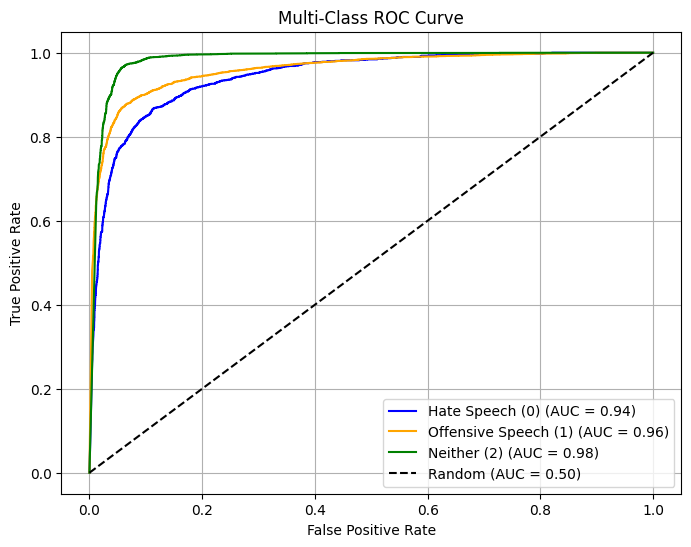

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# **Binarize the output labels (One-Hot Encoding)**
y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2])  # Convert to one-hot format

# **Get predicted probabilities**
y_score = model_cnn.predict(X_test)  # Get probability scores for each class

# **Plot ROC Curves for all classes**
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
class_labels = ['Hate Speech (0)', 'Offensive Speech (1)', 'Neither (2)']

for i in range(3):  # Loop for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])  # Compute FPR & TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# **Plot baseline (random classifier)**
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# **Customize the plot**
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()

# **Show the ROC Curve**
plt.show()


### Confusion Matrix

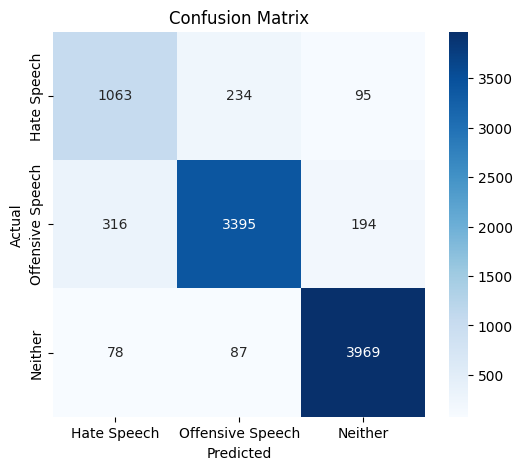

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Hate Speech', 'Offensive Speech', 'Neither'],
            yticklabels=['Hate Speech', 'Offensive Speech', 'Neither'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## MLP

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define model parameters
embedding_dim = 100
num_classes = y.shape[1]
dropout_rate = 0.5

# Input Layer
input_layer = Input(shape=(max_length,))

# Embedding Layer (with pre-trained GloVe or similar)
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

# Flatten the embedding output to feed into MLP
flatten = Flatten()(embedding_layer)

# Dense Layers
dense1 = Dense(128, activation='relu')(flatten)
dropout1 = Dropout(dropout_rate)(dense1)

dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(dropout_rate)(dense2)

# Output Layer
output_layer = Dense(num_classes, activation='softmax')(dropout2)

# Create and compile model
model_mlp = Model(inputs=input_layer, outputs=output_layer)
model_mlp.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model_mlp.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

# Prediction & Evaluation
y_pred = model_mlp.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Hate Speech', 'Offensive Speech', 'Neither'])
print(report)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.6493 - loss: 0.8310 - val_accuracy: 0.7852 - val_loss: 0.5448
Epoch 2/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7822 - loss: 0.5765 - val_accuracy: 0.8053 - val_loss: 0.5052
Epoch 3/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8165 - loss: 0.4865 - val_accuracy: 0.8127 - val_loss: 0.4874
Epoch 4/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8463 - loss: 0.4174 - val_accuracy: 0.8306 - val_loss: 0.4724
Epoch 5/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8639 - loss: 0.3738 - val_accuracy: 0.8346 - val_loss: 0.4964
Epoch 6/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8788 - loss: 0.3264 - val_accuracy: 0.8403 - val_loss: 0.4717
Epoch 7/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8899 - loss: 0.2994 - val_accuracy: 0.8370 - val_loss: 0.4987
Epoch 8/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9012 - loss: 0.2704 - val_accuracy: 0.8447 - va

### Roc Curve

295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


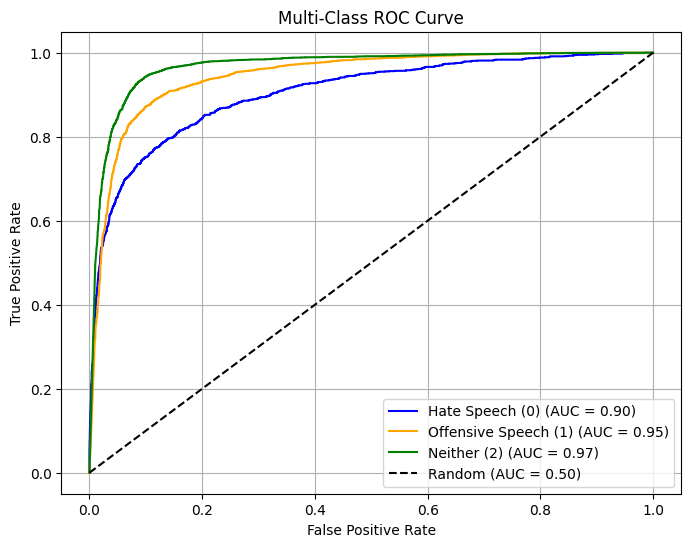

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# **Binarize the output labels (One-Hot Encoding)**
y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2])  # Convert to one-hot format

# **Get predicted probabilities**
y_score = model_mlp.predict(X_test)  # Get probability scores for each class

# **Plot ROC Curves for all classes**
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
class_labels = ['Hate Speech (0)', 'Offensive Speech (1)', 'Neither (2)']

for i in range(3):  # Loop for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])  # Compute FPR & TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# **Plot baseline (random classifier)**
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# **Customize the plot**
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()

# **Show the ROC Curve**
plt.show()


### Confusion Matrix

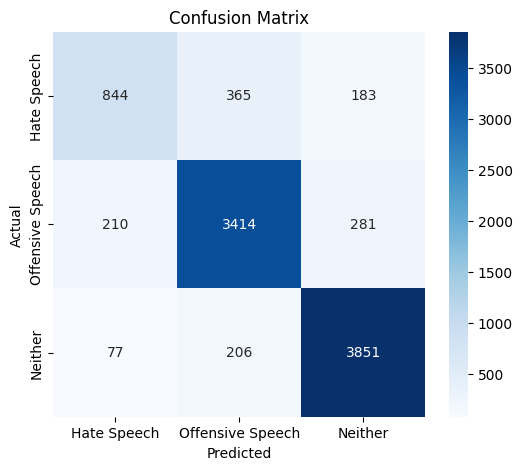

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Hate Speech', 'Offensive Speech', 'Neither'],
            yticklabels=['Hate Speech', 'Offensive Speech', 'Neither'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## BiLSTM

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Bidirectional, LSTM,
                                     GlobalMaxPooling1D, Dense, Dropout, BatchNormalization)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Model Parameters
embedding_dim = 100  # Based on GloVe
num_classes = y.shape[1]  # Assuming y is one-hot encoded
dropout_rate = 0.5

# Input Layer
input_layer = Input(shape=(max_length,))

# # Embedding Layer (Non-trainable GloVe)
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

# Bi-LSTM Layer
bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)

# Global MaxPooling
global_pool = GlobalMaxPooling1D()(bi_lstm)

# Batch Normalization
batch_norm = BatchNormalization()(global_pool)

# Dropout + Dense (first)
drop1 = Dropout(dropout_rate)(batch_norm)
dense1 = Dense(128, activation='relu')(drop1)

# Dropout + Dense (second)
drop2 = Dropout(dropout_rate)(dense1)
dense2 = Dense(64, activation='relu')(drop2)

# Final Dropout + Classification Layer
drop3 = Dropout(dropout_rate)(dense2)
output_layer = Dense(num_classes, activation='softmax')(drop3)

# Create Model
model_bilstm = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model_bilstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
model_bilstm.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

# Evaluate
y_pred = model_bilstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Hate Speech', 'Offensive Speech', 'Neither'])
print(report)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6865 - loss: 0.8405 - val_accuracy: 0.8570 - val_loss: 0.4320
Epoch 2/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8416 - loss: 0.4719 - val_accuracy: 0.8649 - val_loss: 0.3801
Epoch 3/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8480 - loss: 0.4490 - val_accuracy: 0.8730 - val_loss: 0.3532
Epoch 4/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8576 - loss: 0.4025 - val_accuracy: 0.8701 - val_loss: 0.3862
Epoch 5/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8663 - loss: 0.3850 - val_accuracy: 0.8807 - val_loss: 0.3298
Epoch 6/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8726 - loss: 0.3621 - val_accuracy: 0.8851 - val_loss: 0.3129
Epoch 7/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8735 - loss: 0.3516 - val_accuracy: 0.8885 - val_loss: 0.3056
Epoch 8/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8823 - loss: 0.3349 - val

### Roc Curve

295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


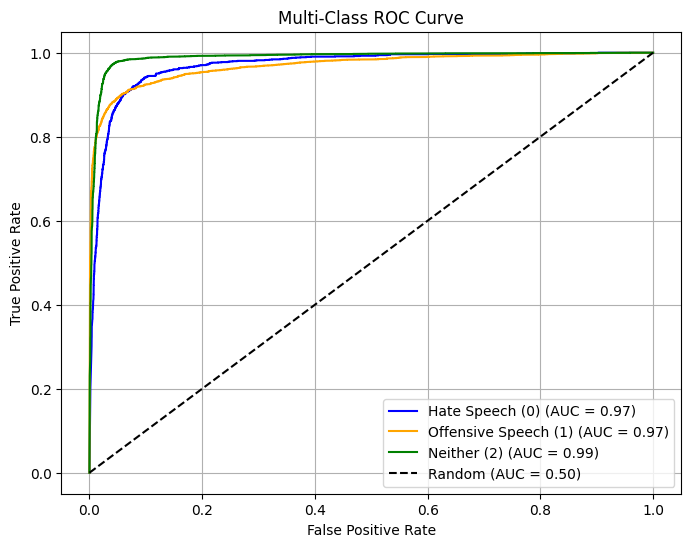

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# **Binarize the output labels (One-Hot Encoding)**
y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2])  # Convert to one-hot format

# **Get predicted probabilities**
y_score = model_bilstm.predict(X_test)  # Get probability scores for each class

# **Plot ROC Curves for all classes**
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
class_labels = ['Hate Speech (0)', 'Offensive Speech (1)', 'Neither (2)']

for i in range(3):  # Loop for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])  # Compute FPR & TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# **Plot baseline (random classifier)**
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# **Customize the plot**
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()

# **Show the ROC Curve**
plt.show()


### Confusion Matrix

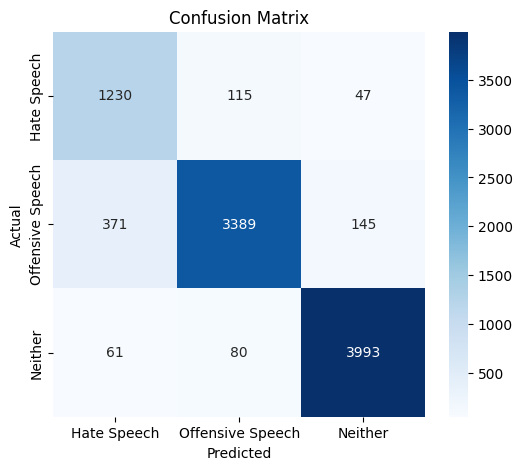

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Hate Speech', 'Offensive Speech', 'Neither'],
            yticklabels=['Hate Speech', 'Offensive Speech', 'Neither'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# TF-IDF + Model

##MLP

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import Counter

# === Load Dataset ===
df = pd.read_csv("augmented_labeled.csv")  # Adjust path if needed
df["tweet"] = df["tweet"].astype(str).fillna("")

# === Extract text and labels ===
texts = df["tweet"].tolist()
labels = df["class"].astype(int).tolist()

# === TF-IDF Vectorization ===
tfidf = TfidfVectorizer(max_features=5000)  # Set number of features (dimensions)
X_tfidf = tfidf.fit_transform(texts).toarray()  # Convert sparse to dense

# === One-hot encode labels ===
y = to_categorical(labels, num_classes=3)

# === Print class distribution ===
print("TF-IDF input shape:", X_tfidf.shape)
print("Original class distribution:", Counter(np.argmax(y, axis=1)))

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# === MLP Model Definition ===
model_tfidf = Sequential()
model_tfidf.add(Dense(256, activation='relu', input_shape=(X_tfidf.shape[1],)))
model_tfidf.add(Dropout(0.5))
model_tfidf.add(Dense(128, activation='relu'))
model_tfidf.add(Dropout(0.5))
model_tfidf.add(Dense(3, activation='softmax'))  # 3 classes

# === Compile Model ===
model_tfidf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# === Train Model ===
model_tfidf.fit(X_train, y_train, batch_size=50, epochs=30, validation_split=0.2)

# === Predict and Evaluate ===
y_pred = model_tfidf.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Hate Speech', 'Offensive Speech', 'Neither'])
print(report)


TF-IDF input shape: (47155, 5000)
Original class distribution: Counter({np.int64(2): 20815, np.int64(1): 19190, np.int64(0): 7150})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7345 - loss: 0.6599 - val_accuracy: 0.8991 - val_loss: 0.2790
Epoch 2/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9192 - loss: 0.2295 - val_accuracy: 0.9148 - val_loss: 0.2407
Epoch 3/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9517 - loss: 0.1432 - val_accuracy: 0.9287 - val_loss: 0.2023
Epoch 4/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9708 - loss: 0.0901 - val_accuracy: 0.9335 - val_loss: 0.2037
Epoch 5/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9781 - loss: 0.0647 - val_accuracy: 0.9396 - val_loss: 0.1916
Epoch 6/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9849 - loss: 0.0478 - val_accuracy: 0.9434 - val_loss: 0.2007
Epoch 7/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9880 - loss: 0.0366 - val_accuracy: 0.9437 - val_loss: 0.2042
Epoch 8/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9905 - loss: 0.0295 - val_accuracy: 0

In [ ]:
model_tfidf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,940,619 (15.03 MB)

 Trainable params: 1,313,539 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,627,080 (10.02 MB)

###ROC-Curve

295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


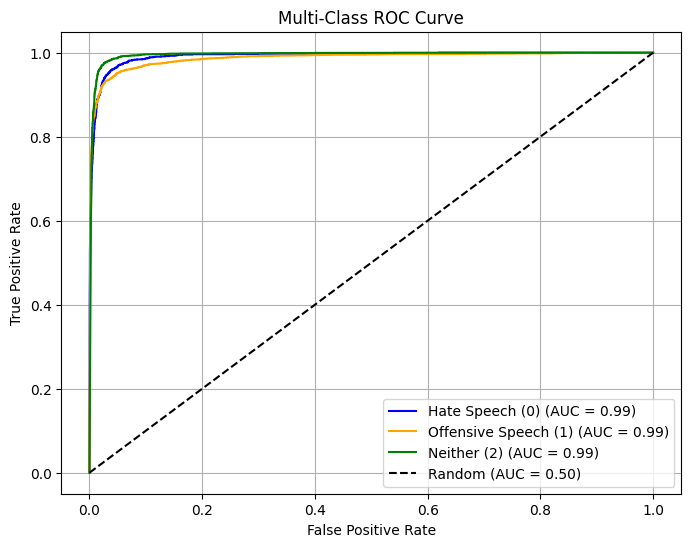

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# **Binarize the output labels (One-Hot Encoding)**
y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2])  # Convert to one-hot format

# **Get predicted probabilities**
y_score = model_tfidf.predict(X_test)  # Get probability scores for each class

# **Plot ROC Curves for all classes**
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
class_labels = ['Hate Speech (0)', 'Offensive Speech (1)', 'Neither (2)']

for i in range(3):  # Loop for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])  # Compute FPR & TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

# **Plot baseline (random classifier)**
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# **Customize the plot**
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()

# **Show the ROC Curve**
plt.show()


### Confusion Matrix

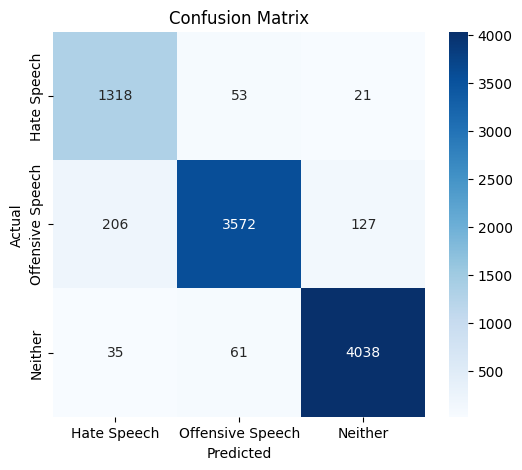

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Hate Speech', 'Offensive Speech', 'Neither'],
            yticklabels=['Hate Speech', 'Offensive Speech', 'Neither'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## XGB

In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Dataset ===
df = pd.read_csv("augmented_labeled.csv")
df["tweet"] = df["tweet"].astype(str).fillna("")

# === Extract text and labels ===
texts = df["tweet"].tolist()
labels = df["class"].astype(int).tolist()

# === TF-IDF Vectorization ===
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # added bigrams
X_tfidf = tfidf.fit_transform(texts).toarray()

# === Print class distribution ===
print("TF-IDF input shape:", X_tfidf.shape)
print("Original class distribution:", Counter(labels))

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42, stratify=labels)

# === XGBoost Model Definition ===
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# === Early Stopping Setup ===
X_train_full, X_val, y_train_full, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

xgb_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# === Predict and Evaluate ===
y_pred_probs = xgb_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# === Classification Report ===
report = classification_report(y_test, y_pred, target_names=['Hate Speech', 'Offensive Speech', 'Neither'])
print(report)


TF-IDF input shape: (47155, 5000)
Original class distribution: Counter({2: 20815, 1: 19190, 0: 7150})


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:25:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                  precision    recall  f1-score   support

     Hate Speech       0.79      0.51      0.62      1430
Offensive Speech       0.89      0.88      0.88      3838
         Neither       0.87      0.99      0.93      4163

        accuracy                           0.87      9431
       macro avg       0.85      0.79      0.81      9431
    weighted avg       0.87      0.87      0.86      9431



### Confusion Matrix

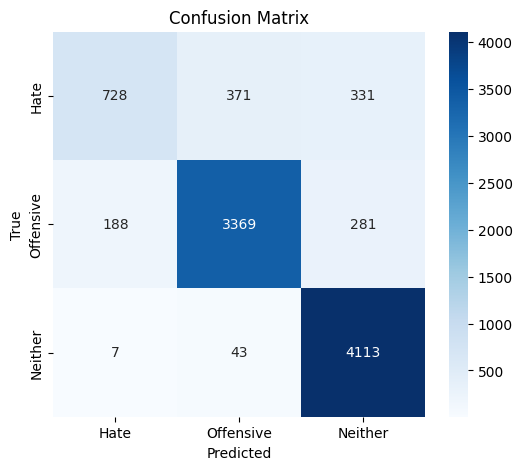

In [ ]:
# === Optional: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate', 'Offensive', 'Neither'], yticklabels=['Hate', 'Offensive', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Roc Curve

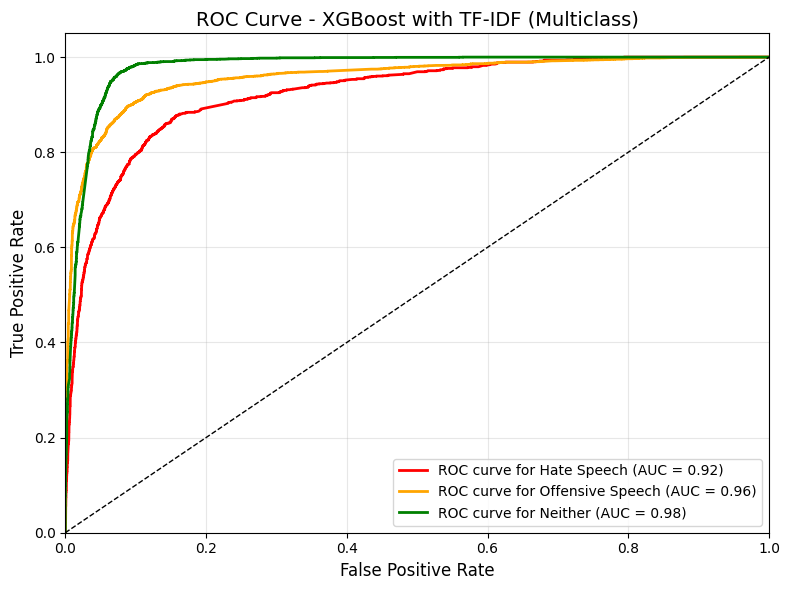

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# === Binarize the output (needed for multiclass ROC) ===
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming labels: 0=Hate, 1=Offensive, 2=Neither
n_classes = y_test_bin.shape[1]

# === Compute ROC curve and ROC area for each class ===
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# === Plot all ROC curves ===
plt.figure(figsize=(8, 6))
colors = ['red', 'orange', 'green']
class_names = ['Hate Speech', 'Offensive Speech', 'Neither']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - XGBoost with TF-IDF (Multiclass)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## SVM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# === Load Dataset ===
df = pd.read_csv("augmented_labeled.csv")
df["tweet"] = df["tweet"].astype(str).fillna("")

# === Extract text and labels ===
texts = df["tweet"].tolist()
labels = df["class"].astype(int).tolist()

# === TF-IDF Vectorization ===
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Unigrams + Bigrams
X_tfidf = tfidf.fit_transform(texts)

# === Print class distribution ===
print("TF-IDF input shape:", X_tfidf.shape)
print("Original class distribution:", Counter(labels))

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, labels, test_size=0.2, random_state=42, stratify=labels
)

# === SVM Classifier (Linear Kernel for Text) ===
svm_model = LinearSVC(C=1.0, max_iter=10000)
svm_model.fit(X_train, y_train)

# === Predict and Evaluate ===
y_pred = svm_model.predict(X_test)

# === Classification Report ===
report = classification_report(
    y_test, y_pred,
    target_names=['Hate Speech', 'Offensive Speech', 'Neither']
)
print(report)


TF-IDF input shape: (47155, 5000)
Original class distribution: Counter({2: 20815, 1: 19190, 0: 7150})
                  precision    recall  f1-score   support

     Hate Speech       0.80      0.74      0.77      1430
Offensive Speech       0.91      0.89      0.90      3838
         Neither       0.93      0.98      0.95      4163

        accuracy                           0.91      9431
       macro avg       0.88      0.87      0.88      9431
    weighted avg       0.90      0.91      0.90      9431



###Confusion Matrix

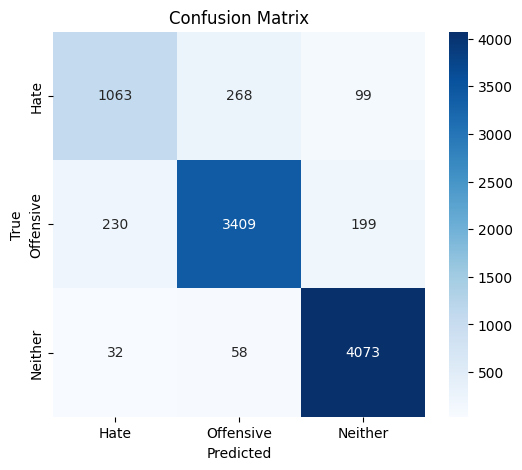

In [ ]:
1095# === Optional: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate', 'Offensive', 'Neither'], yticklabels=['Hate', 'Offensive', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

svm_model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))
svm_model.fit(X_train, y_train)  # y_train must be one-hot encoded (binarized)
y_pred_probs = svm_model.predict_proba(X_test)

# === Binarize the output ===
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # use original labels here (not one-hot)
n_classes = y_test_bin.shape[1]

# === Compute ROC curves and AUC for each class ===
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# === Plot all ROC curves ===
plt.figure(figsize=(8, 6))
colors = ['red', 'orange', 'green']
class_names = ['Hate Speech', 'Offensive Speech', 'Neither']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - SVM with TF-IDF (Multiclass)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
